# LAB 4: Image Degradation, Restoration, and Compression Techniques

`By: Sabin Dahal (022bscit035)`

Image degradation refers to the loss of quality due to noise, blur, or distortion. Restoration aims to recover the original image by removing these effects. Compression reduces image size for storage or transmission, balancing quality and file size using methods like lossless and lossy compression.

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

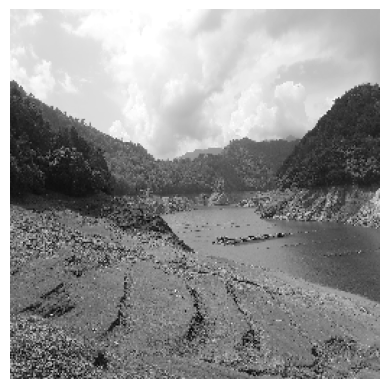

In [20]:
img = cv.imread('scenery.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, (256, 256))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [21]:
# applying gaussian noise without inbuilt function
def gaussian_noise(image, mean=0, sigma=25):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)  # Ensure pixel values are in valid range
    return noisy.astype(np.uint8)


In [22]:
#applying salt and pepper noise without inbuilt function
def salt_and_pepper_noise(image, salt_prob=0.2, pepper_prob=0.2):
    noisy = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Add salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 255

    # Add pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy



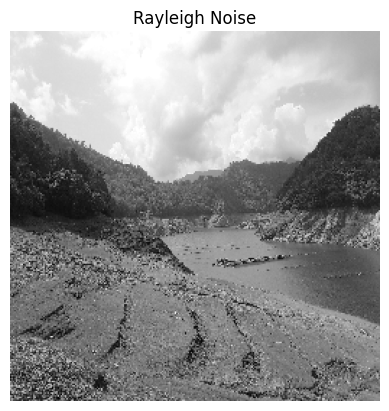

In [23]:
#implement reyleigh noise without inbuilt function
def rayleigh_noise(image, scale=1):
    row, col = image.shape
    rayleigh = np.random.rayleigh(scale, (row, col))
    noisy = image + rayleigh
    noisy = np.clip(noisy, 0, 255)  # Ensure pixel values are in valid range
    return noisy.astype(np.uint8)

rayleigh= rayleigh_noise(img)
plt.imshow(rayleigh, cmap='gray')# Display the noisy image
plt.axis('off')
plt.title('Rayleigh Noise')
plt.show()

In [24]:
#implement erlang noise without inbuilt function
def erlang_noise(image, k=2, scale=1):
    row, col = image.shape
    erlang = np.random.gamma(k, scale, (row, col))
    noisy = image + erlang
    noisy = np.clip(noisy, 0, 255)  # Ensure pixel values are in valid range
    return noisy.astype(np.uint8)

In [25]:
#implement uniform noise without inbuilt function
def uniform_noise(image, low=0, high=255):
    row, col = image.shape
    uniform = np.random.uniform(low, high, (row, col))
    noisy = image + uniform
    noisy = np.clip(noisy, 0, 255)  # Ensure pixel values are in valid range
    return noisy.astype(np.uint8)

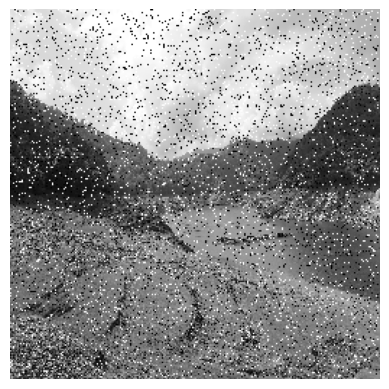

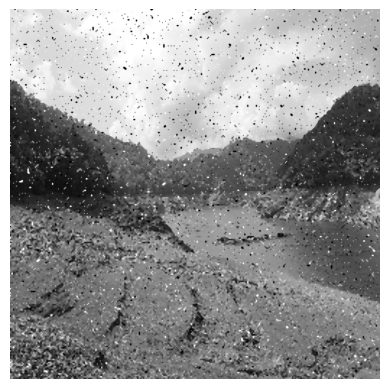

In [ ]:
#image restoration using mean filter without inbuilt function
def median_filter(image, kernel_size=3):
    pad = kernel_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel_size, j:j + kernel_size]
            filtered_image[i, j] = np.median(region)

    return filtered_image.astype(np.uint8)

degraded_image = salt_and_pepper_noise(img, salt_prob=0.05, pepper_prob=0.05)
degraded_image = cv.resize(degraded_image, (1000, 1000), interpolation=cv.INTER_AREA)
plt.imshow(degraded_image, cmap='gray')
plt.axis('off')
plt.show()
restored_image = median_filter(degraded_image, kernel_size=5)
plt.imshow(restored_image, cmap='gray')
plt.axis('off')
plt.show()

In [27]:
def dft_image(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    return dft_shift

def idft_image(dft_shift):
    f_ishift = np.fft.ifftshift(dft_shift)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [28]:
def create_ideal_filter(shape, low_cutoff, high_cutoff, band_type='pass'):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            D = np.sqrt((u - crow)**2 + (v - ccol)**2)
            if band_type == 'pass':
                if low_cutoff <= D <= high_cutoff:
                    mask[u, v] = 1
            elif band_type == 'reject':
                if D < low_cutoff or D > high_cutoff:
                    mask[u, v] = 1
    return mask

In [29]:
def create_butterworth_filter(shape, low_cutoff, high_cutoff, n, band_type='pass'):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            D = np.sqrt((u - crow)**2 + (v - ccol)**2)
            if band_type == 'reject':
                mask[u, v] = 1 / (1 + ((D * (high_cutoff - low_cutoff)) / (D**2 - low_cutoff * high_cutoff))**(2*n))
            elif band_type == 'pass':
                mask[u, v] = 1 - (1 / (1 + ((D * (high_cutoff - low_cutoff)) / (D**2 - low_cutoff * high_cutoff))**(2*n)))
    return mask

In [30]:
def create_gaussian_filter(shape, low_cutoff, high_cutoff, band_type='pass'):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            D = np.sqrt((u - crow)**2 + (v - ccol)**2)
            if band_type == 'pass':
                mask[u, v] = np.exp(-((D**2 - low_cutoff * high_cutoff)**2) / (D**2 * (high_cutoff - low_cutoff)**2 + 1e-5))
            elif band_type == 'reject':
                mask[u, v] = 1 - np.exp(-((D**2 - low_cutoff * high_cutoff)**2) / (D**2 * (high_cutoff - low_cutoff)**2 + 1e-5))
    return mask

In [31]:
def plot(rows, cols, images, titles):
    plt.figure(figsize=(15, 10))
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, i * cols + j + 1)
            if type(images[i*cols+j][0]) == np.ndarray:
                plt.imshow(images[i*cols+j], cmap='gray')
            else:
                plt.bar(range(256), images[i*cols+j])
            plt.title(titles[i*cols+j])

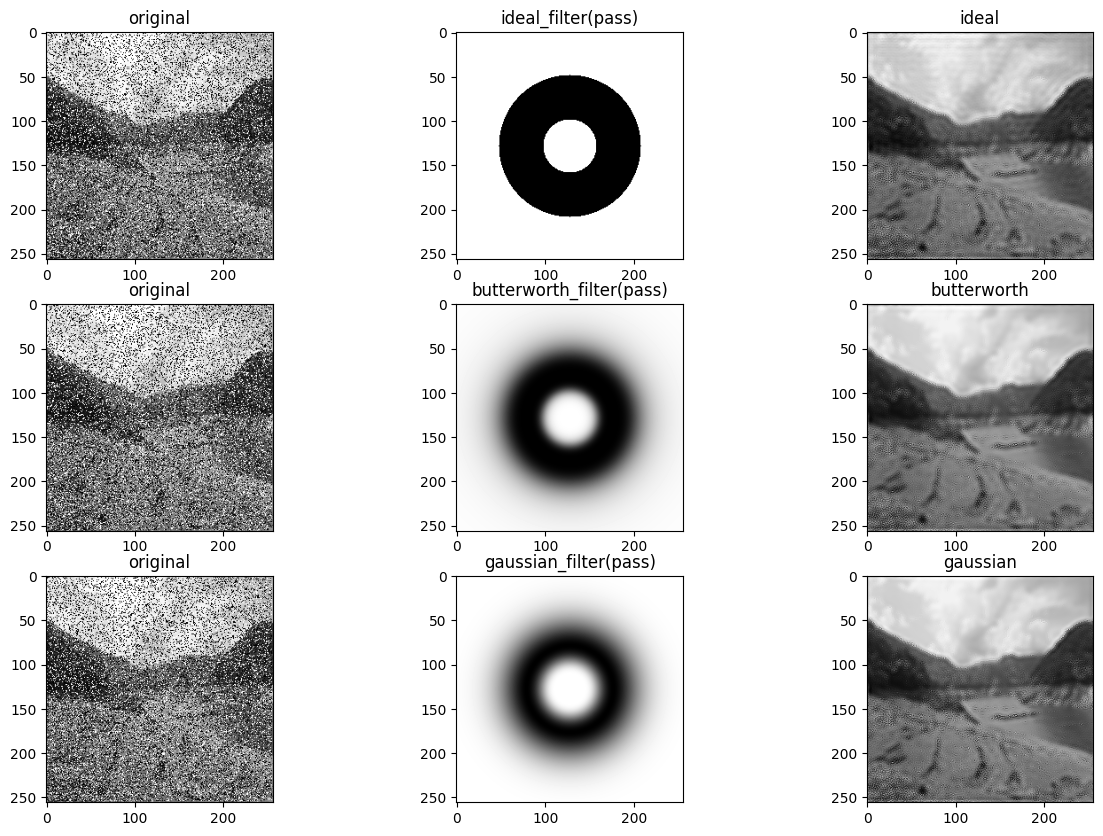

In [ ]:
# DFT
dft = dft_image(img)

# Filters
ideal_filter = create_ideal_filter(img.shape, 30, 80, band_type='reject')
butterworth_filter = create_butterworth_filter(img.shape, 30, 80, n=2, band_type='reject')
gaussian_filter = create_gaussian_filter(img.shape, 30, 80, band_type='reject')

# Apply filters once
filtered_ideal = idft_image(dft * ideal_filter)
filtered_butterworth = idft_image(dft * butterworth_filter)
filtered_gaussian = idft_image(dft * gaussian_filter)

# Plot
plot(3, 3,
     [salt_and_pepper_noise(img), ideal_filter, filtered_ideal,
      salt_and_pepper_noise(img), butterworth_filter, filtered_butterworth,
      salt_and_pepper_noise(img), gaussian_filter, filtered_gaussian],
     ['original','ideal_filter(reject)','ideal',
      'original','butterworth_filter(reject)','butterworth',
      'original','gaussian_filter(reject)','gaussian'])


In [ ]:
#implement encoding using huffman coding without inbuilt function
def huffman_encoding(data):
    from collections import Counter, namedtuple
    import heapq

    # Create a frequency dictionary
    frequency = Counter(data)

    # Create a priority queue (min-heap)
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        low1 = heapq.heappop(heap)
        low2 = heapq.heappop(heap)
        for pair in low1[1:]:
            pair[1] = '0' + pair[1]
        for pair in low2[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [low1[0] + low2[0]] + low1[1:] + low2[1:])

    huffman_tree = sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
    return {symbol: code for symbol, code in huffman_tree}# Return the Huffman codes dictionary

def huffman_decoding(encoded_data, huffman_codes):
    decoded_output = []
    current_code = ""
    code_to_symbol = {code: symbol for symbol, code in huffman_codes.items()}
    for bit in encoded_data:
        current_code += bit
        if current_code in code_to_symbol:
            decoded_output.append(code_to_symbol[current_code])
            current_code = ""
    return ''.join(decoded_output)  # Return the decoded string
#test the function
data = "saaabin"
huffman_codes = huffman_encoding(data)
encoded_data = ''.join(huffman_codes[char] for char in data)
decoded_data = huffman_decoding(encoded_data, huffman_codes)
print("Original Data:", data)
print("Encoded Data:", encoded_data)
print("Decoded Data:", decoded_data)
# Check if the decoded data matches the original data
if decoded_data == data:
    print("Huffman encoding and decoding successful!")


Counter({'a': 3, 's': 1, 'b': 1, 'i': 1, 'n': 1})
Original Data: saaabin
Encoded Data: 111000100101110
Decoded Data: saaabin
Huffman encoding and decoding successful!
